# Figures for CDC2025 Paper

This Notebook contains the code used to produce the figures appearing in our paper for the Conference on Decision and Control (CDC 2025) invited session on "Neuromorphic systems and control".

## Preliminaries

In [ ]:
import numpy as np

import scipy.optimize as opt
from scipy.ndimage import gaussian_filter
from clustercode.SNODdesc import *

import matplotlib.pyplot as plt

import pickle as pkl


## Two parameter bifurcation 
This figure consists of a box with $\mu_0$ values on the horizontal and $b$ values on the vertical. The plot type is an imshow, where each pixel will represent a point in parameter space, and it is colored acording to the dynamical properties of the system for that parameter combination. White corresponds to no spiking(no limit cycle), while other pixels are colored according to the frequency of spiking. 

The line separating the spiking and non-spiking regions is computed numerically and plotted over the imshow, with color corresponding to the bifurcation that leads to the appearance of the spike limit cycle. 

In [2]:
# Define the parameters

params = [1/20, 1.0, 1.0, 3.0, 22.0, 0.8, 0.0] # epsilon, a, d, k, k_s, mu0, b

epsilon = params[0]
a = params[1]
d = params[2]
k = params[3]
k_s = params[4]
mu0 = params[5]
b = params[6]

# These are the parameter ranges we simulated in the cluster
mu0s = list(np.linspace(0.7, 1.1, 500))
Is = list(np.linspace(0.0, 0.1, 500))

# Object is a numpy array of frequencies multiplies by 1000
freqs = pkl.load(open('pickles/SNODdesc/desc_newfine.pkl', 'rb'))

# Apply Gaussian slightly blur to the frequency data to remove small artifacts due to numerical imprecision
blurred_freqs = gaussian_filter(freqs, sigma=5.0)

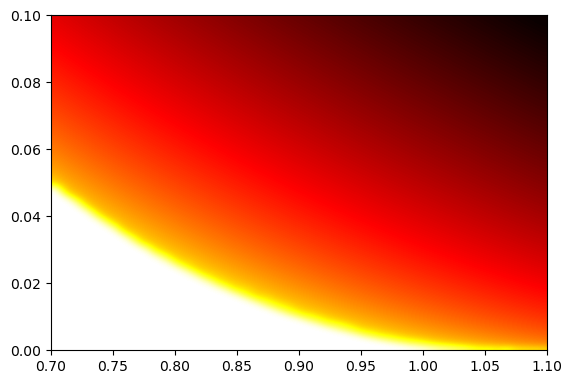

In [3]:
plt.imshow(blurred_freqs.T, extent=[0.7, 1.1, 0.0, 0.1], vmax=0.12, origin="lower", aspect=2.7, cmap="hot_r")

In [4]:
# This function computes the real roots of the determinant and trace polynomials of the Jacobian matrix as described in the paper
def find_real_roots(a, d, k, k_s, mu0, epsilon):
    # Define the coefficients as per the paper
    c0 = a*mu0 - d
    c1 = (3*a*k - a*d*d*mu0)
    c2 = (3*a*d*d*k + a*k_s)
    c3 = a*d*d*k_s
    C0 = c0
    C1 = c1
    C2 = c2 + 4*a*k_s
    C3 = 5*c3

    # Find real roots of determinant and trace
    det_roots = np.roots([C3, -C2, C1, C0])
    det_real_roots = det_roots[np.isreal(det_roots)].real
    det_real_roots = [rt**(1/2) for rt in det_real_roots]

    tr_roots = np.roots([c3, -c2, c1, c0-epsilon])
    tr_real_roots = tr_roots[np.isreal(tr_roots)].real
    tr_real_roots = [rt**(1/2) for rt in tr_real_roots]

    return det_real_roots, tr_real_roots

In [5]:
# Now we compute the critical input (b) value for each mu0 value
mu0s = []
bbs = []
bifchange = 0

for mu0 in np.linspace(0.7, 1.0, 100):
     
    def h_b(b, z):
        return -d*z + np.tanh(a*z * (-k_s*z**4 + k*z**2 + mu0) + b)

    det_real_roots, tr_real_roots = find_real_roots(a, d, k, k_s, mu0, epsilon)

    z_tr = min(tr_real_roots)


    if len(det_real_roots) > 0 and (z_det:=min(det_real_roots)) < z_tr:
        try:
            b_crit = opt.root_scalar(h_b, args=(z_det,), bracket=[0, 1]).root
        except ValueError:
            if b_crit == np.inf:
                b_crit = 0.0

        if bifchange == 0:
            bifchange = len(bbs)

    else:
        try:
            b_crit = opt.root_scalar(h_b, args=(z_tr,), bracket=[0, 1]).root
        except ValueError:
            if b_crit == np.inf:
                b_crit = 0.0

    mu0s.append(mu0)
    bbs.append(b_crit)

/var/folders/0q/gdq5kr0s6n51gv9rlwbdfwlr0000gn/T/ipykernel_6972/32528707.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(mu0s[bifchange:], bbs[bifchange:], 'k-', linewidth=3, color='#888')


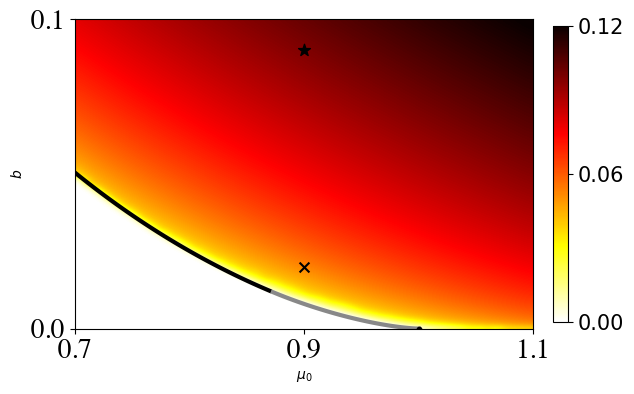

In [ ]:
# Set up the figure
plt.imshow(blurred_freqs.T, extent=[0.7, 1.1, 0.0, 0.1], vmax=0.12, origin="lower", aspect=2.7, cmap="hot_r")

# Labeling and colorbar
plt.xlabel(r"$\mu_0$")
plt.ylabel(r"$b$")
plt.xticks([0.7, 0.9, 1.1])
plt.yticks([0.0, 0.1])
plt.xticks(fontname='Times', fontsize=20)
plt.yticks(fontname='Times', fontsize=20)
cbar = plt.colorbar(fraction=0.036, pad=0.04, shrink=0.8)
cbar.ax.tick_params(labelsize=15)  
cbar.set_ticks([0, 0.06, 0.12]) 

# Plot Hopf bifurcation points
plt.plot(mu0s[:bifchange], bbs[:bifchange], 'k-', linewidth=3)
# Plot saddle-node bifurcation points
plt.plot(mu0s[bifchange:], bbs[bifchange:], 'k-', linewidth=3, color='#888')

# Plot pitchfork bifurcation point above the x-axis
plt.scatter([d/a], [0.0], color='k', s=10, zorder=5)

# Plot point at (0.8, 0.1) and (0.8, 0.03) to use as examples in the text
plt.scatter([0.9], [0.09], color='k', s=80, zorder=5, marker='*')
plt.scatter([0.9], [0.02], color='k', s=50, zorder=5, marker='x')

plt.savefig("figs/twoparVSfreq.svg", dpi=300)

## Miscellaneous
A couple of extra blocks of code that don't produce figures, but are useful for exploration 

In [7]:
# This block of code computes the critical b value for given parameters

a = 1.0
d = 1.0
k = 3.0
k_s = 22.0
epsilon = 1/20
mu0 = 0.90

det_real_roots, tr_real_roots = find_real_roots(a, d, k, k_s, mu0, epsilon)

z_tr = min(tr_real_roots)

try:
    b_crit = opt.root_scalar(h_b, args=(z_tr,), bracket=[0, 1]).root
except ValueError:
    b_crit = np.inf

if len(det_real_roots) > 0:
    z_det = min(det_real_roots)
    b_crit = min(b_crit, opt.root_scalar(h_b, args=(z_det,), bracket=[0, 1]).root)

b_crit

0.00785384982736517

Trajectory did not converge to a stable limit cycle in the given time.


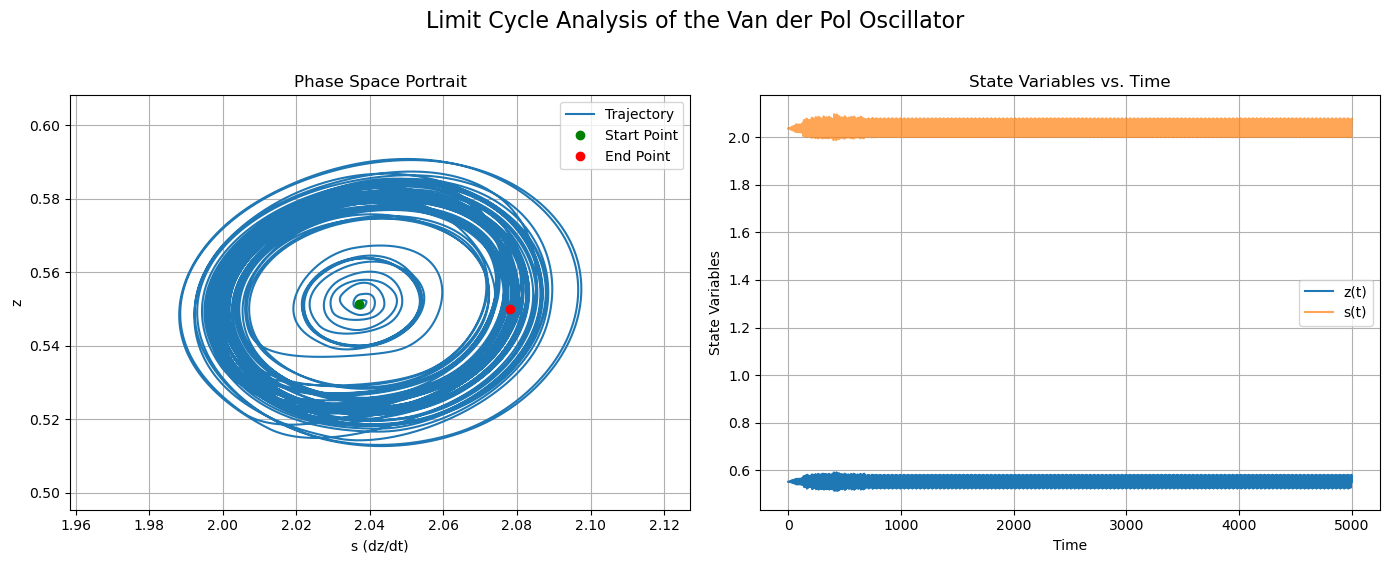

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def SNOD(t, x, params):
    z, s = x
    epsilon, a, d, k, k_s, mu0, b = params
    dzdt = -d*z + np.tanh(a*z*(k*z**2 + mu0 - s) + b)
    dsdt = epsilon * (- s + k_s*z**4)
    return [dzdt, dsdt]

def detect_limit_cycle_and_frequency(system_func, initial_conditions, t_span, t_eval, params, do_verbose = False):
    # Solve the system of ODEs
    sol = solve_ivp(
        lambda t, z: system_func(t, z, params=params),
        t_span,
        initial_conditions,
        t_eval=t_eval,
        dense_output=True
    )

    # Use the x-component of the solution to find peaks
    x_trajectory = sol.y[0]
    
    # We look for peaks after a certain transient time to ensure we are on the attractor
    transient_time_index = len(t_eval) // 2
    
    # Find peaks in the second half of the time series data
    peaks, _ = find_peaks(x_trajectory[transient_time_index:])
    
    # Adjust peak indices to correspond to the full time series
    peaks += transient_time_index

    frequency = None
    if len(peaks) > 2:
        # Calculate the time differences between consecutive peaks
        peak_times = sol.t[peaks]
        periods = np.diff(peak_times)
        
        # If the standard deviation of the periods is small, we assume a stable cycle
        if np.std(periods) / np.mean(periods) < 0.01: # Threshold for stability
            mean_period = np.mean(periods)
            frequency = 1 / mean_period
            if do_verbose:
                print(f"Limit cycle detected!")
                print(f"  - Estimated Period: {mean_period:.4f} time units")
                print(f"  - Estimated Frequency: {frequency:.4f} Hz")
        else:
            if do_verbose:
                print("Trajectory did not converge to a stable limit cycle in the given time.")
    else:
        if do_verbose:
            print("Not enough peaks found to reliably detect a limit cycle.")

    return sol, frequency

def plot_results(solution, frequency):
    t = solution.t
    z = solution.y[0]
    s = solution.y[1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Limit Cycle Analysis of the Van der Pol Oscillator', fontsize=16)

    # Plot 1: Phase Space (s vs z)
    ax1.plot(s, z, label='Trajectory')
    ax1.plot(s[0], z[0], 'go', label='Start Point')
    ax1.plot(s[-1], z[-1], 'ro', label='End Point')
    ax1.set_xlabel('s (dz/dt)')
    ax1.set_ylabel('z')
    ax1.set_title('Phase Space Portrait')
    ax1.grid(True)
    ax1.legend()
    ax1.axis('equal')

    # Plot 2: Time Series (z(t) and s(t))
    ax2.plot(t, z, label='z(t)')
    ax2.plot(t, s, label='s(t)', alpha=0.7)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('State Variables')
    ax2.set_title('State Variables vs. Time')
    ax2.grid(True)
    ax2.legend()
    
    if frequency:
        fig.text(0.5, 0.02, f'Estimated Limit Cycle Frequency: {frequency:.4f} Hz', ha='center', fontsize=12, color='blue')

    plt.tight_layout(rect=[0, 0.05, 1, 0.96])
    plt.show()


# --- System Parameters ---
params = [1/20, 1.0, 1.0, 3.0, 22.0, 0.8, 0.8] # epsilon, a, d, k, k_s, mu0, b

# --- Simulation Parameters ---
z_zeros = find_all_roots(lambda z: SA_SNOD(0, [z, params[4]*z**4], params)[0], [-1/params[1], 1/params[1]])
z_bar = z_zeros[0]
initial_conditions = [z_bar, params[4]*z_bar**4]+np.random.randn(2)*0.001  # Starting point
t_start = 0
t_end = 5000
num_points = t_end * 100  # 100 points per time unit

# Time points for evaluation
t_span = (t_start, t_end)
t_eval = np.linspace(t_start, t_end, num_points)

# --- Run Detection and Plotting ---
solution, detected_frequency = detect_limit_cycle_and_frequency(
    SNOD,
    initial_conditions,
    t_span,
    t_eval,
    params, 
    do_verbose = True
)

plot_results(solution, detected_frequency)

### Input vs. Freq. Plot

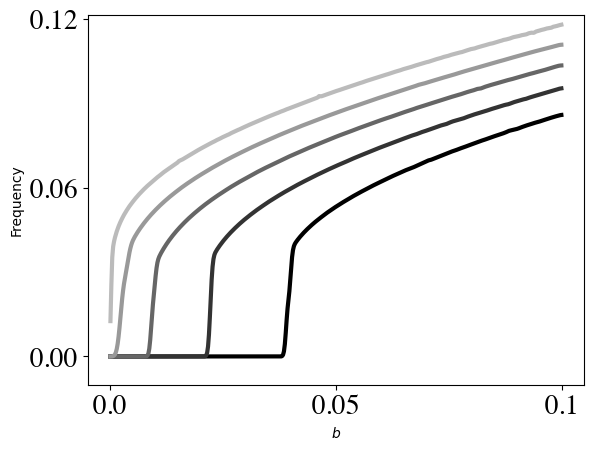

In [9]:
def plot_slice(i, sigma=0, color="blue"):
    smoothed_freqs = gaussian_filter(freqs[i, :], sigma=sigma)
    plt.plot(range(500), smoothed_freqs, color=color, linewidth=3)
    plt.ylim(-0.01, np.max(freqs))  # Set max y to slightly above the maximum value
    plt.xlabel(r"$b$")
    plt.xticks([0, 250, 500], [0.0, 0.05, 0.1])
    plt.xticks(fontname='Times', fontsize=20)
    plt.yticks([0.0, 0.06, 0.12])
    plt.yticks(fontname='Times', fontsize=20)
    plt.ylabel("Frequency")

plot_slice(50, 2, "#000")
plot_slice(152, 2, "#333")
plot_slice(253, 2, "#666")
plot_slice(351, 3, "#999")
plot_slice(450, 1, "#bbb")

plt.savefig("figs/freqslices.svg", format="svg")

## Spikes display
Code to produce figures of spikes that were used as inlays in the bifurcation diagram figures in the paper. Parameters are set to correspond with the ones used for the bifurcation diagrams.

In [10]:
def plot_spikes(sol, t_int, color="blue", yticks=[]):
    plt.plot(sol.t[:t_int*200], sol.y[0][:t_int*200], color=color, linewidth=3)
    plt.xlim(0, t_int)
    plt.ylim(np.min(sol.y[0])-0.05, np.max(sol.y[0])+0.05)
    plt.xticks([0, 200, 400, 600], fontsize = 20, labels=[0, 2, 4, 6])
    plt.yticks(yticks, fontsize=20)
    plt.tick_params(axis='both', which='both', width=1, length=3, direction='in')
    plt.xticks(fontname='Times')
    plt.yticks(fontname='Times')
    plt.gca().spines['top'].set_linewidth(1)
    plt.gca().spines['right'].set_linewidth(1)
    plt.gca().spines['left'].set_linewidth(1)
    plt.gca().spines['bottom'].set_linewidth(1)
    plt.gcf().set_figheight(3)

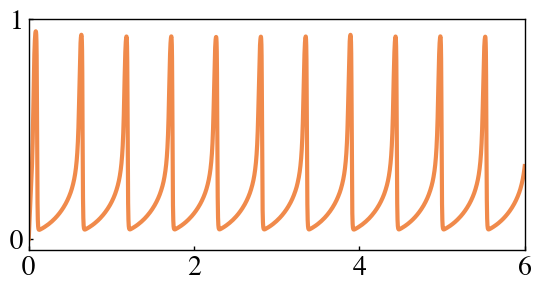

In [11]:
x0 = [0.0,0.0]

# Set mu0 and b
params[5] = 0.8
params[6] = 0.1

t_int = 600
t = np.linspace(0, t_int, t_int*200) 
sol = solve_ivp(SA_SNOD, [0, t_int], x0, args=(params,), events=[esc_event], t_eval=t) # simulate the system

plot_spikes(sol, t_int, "#f08a4b", yticks=[0, 1])
plt.savefig("figs/SA_SNODspike(+).svg", format="svg")

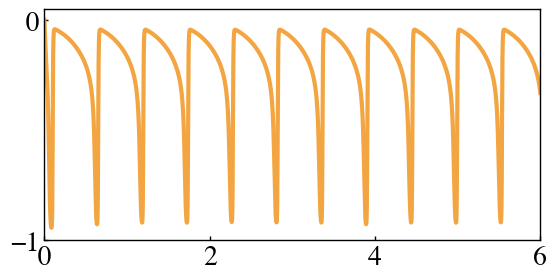

In [12]:
x0 = [0.0,0.0]

# Set mu0 and b
params[5] = 0.8
params[6] = -0.1

t_int = 600
t = np.linspace(0, t_int, t_int*200) 
sol = solve_ivp(SA_SNOD, [0, t_int], x0, args=(params,), events=[esc_event], t_eval=t) # simulate the system

plot_spikes(sol, t_int, "#f2a541", yticks=[0, -1])
plt.savefig("figs/SA_SNODspike(-).svg", format="svg")

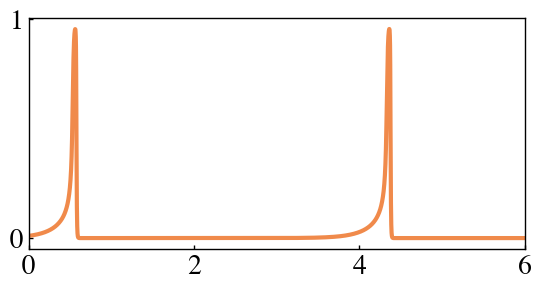

In [13]:
x0 = [0.01,0.0]

# Set mu0 and b
params[5] = 1.05
params[6] = 0.0

t_int = 600
t = np.linspace(0, t_int, t_int*200) 
sol = solve_ivp(SA_SNOD, [0, t_int], x0, args=(params,), events=[esc_event], t_eval=t) # simulate the system

plot_spikes(sol, t_int, "#f08a4b", yticks=[0, 1])
plt.savefig("figs/SA_SNODmu0spike(+).svg", format="svg")

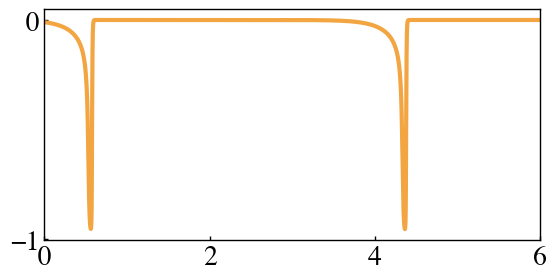

In [14]:
x0 = [-0.01,0.0]

# Set mu0 and b
params[5] = 1.05
params[6] = 0.0

t_int = 600
t = np.linspace(0, t_int, t_int*200) 
sol = solve_ivp(SA_SNOD, [0, t_int], x0, args=(params,), events=[esc_event], t_eval=t) # simulate the system

plot_spikes(sol, t_int, "#f2a541", yticks=[0, -1])
plt.savefig("figs/SA_SNODmu0spike(-).svg", format="svg")

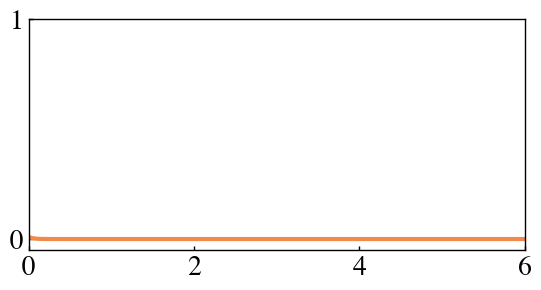

In [15]:
x0 = [0.01,0.0]

# Set mu0 and b
params[5] = 0.8
params[6] = 0.0

t_int = 600
t = np.linspace(0, t_int, t_int*200) 
sol = solve_ivp(SA_SNOD, [0, t_int], x0, args=(params,), events=[esc_event], t_eval=t) # simulate the system

plot_spikes(sol, t_int, "#f08a4b", yticks=[0, 1])
plt.savefig("figs/SA_SNODspike(+)b_0.svg", format="svg")

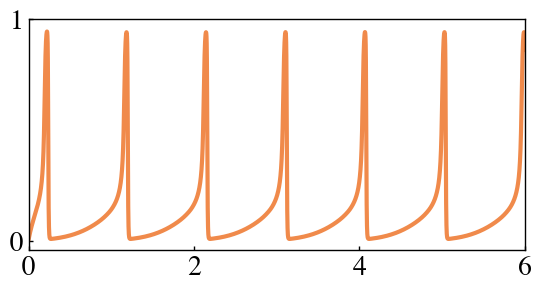

In [16]:
x0 = [0.01,0.0]

# Set mu0 and b
params[5] = 0.9
params[6] = 0.02

t_int = 600
t = np.linspace(0, t_int, t_int*200) 
sol = solve_ivp(SA_SNOD, [0, t_int], x0, args=(params,), events=[esc_event], t_eval=t) # simulate the system

plot_spikes(sol, t_int, "#f08a4b", yticks=[0, 1])
plt.savefig("figs/SA_SNODspike(+)b_0p05.svg", format="svg")

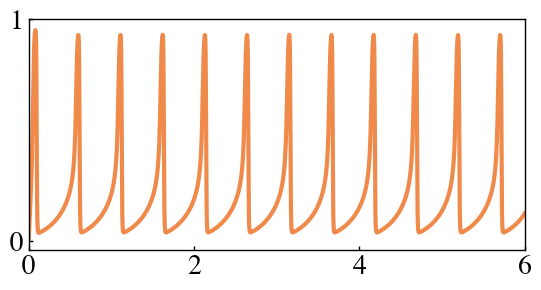

In [17]:
x0 = [0.01,0.0]

# Set mu0 and b
params[5] = 0.9
params[6] = 0.09

t_int = 600
t = np.linspace(0, t_int, t_int*200) 
sol = solve_ivp(SA_SNOD, [0, t_int], x0, args=(params,), events=[esc_event], t_eval=t) # simulate the system

plot_spikes(sol, t_int, "#f08a4b", yticks=[0, 1])
plt.savefig("figs/SA_SNODspike(+)b_0p1.svg", format="svg")